In [1]:
from t2_flujo import *
import folium
import matplotlib.pyplot as plt
import funciones
import parametros

# pre pros

In [2]:
N = []
for a in range(len(nodos_totales)):
    lista = nodos_totales.loc[a].to_list()
    nodo = funciones.Node(lista[0], lista[1], lista[2], lista[3], lista[4])
    N.append(nodo)

# DICCIONARIO DE ID EN EL MAPA Y EL ID QUE LE PUSE A LOS NODOS

ids = nodos_totales['id_nodo'].to_list()
nombres = nodos_totales['id'].to_list()

dict_ids_nombres = {}

for a in range(len(ids)):
    dict_ids_nombres[ids[a]] = nombres[a]

for a in range(1,parametros.P+1):
    nombres.append(f'PB{a}')

In [3]:
# Como se especifica que el transporte es desde los nodos de produccion a bodegas y demanda, y de los nodos
# de bodega a los nodos de demanda, elimino los arcos que no sirven para del grafo de todos los nodos conectados entre si.

# list(grafo_vial.edges(data=True))[par][origen/destino]
grafo_vial_nuevo = grafo_vial.copy()
lista_pares_nodos = list(grafo_vial_nuevo.edges())

for b in range(len(lista_pares_nodos)):
    a = lista_pares_nodos[b]
    
    O = nodos_totales[nodos_totales['id_nodo'] == a[0]]
    O_pos = O.index[0]

    D = nodos_totales[nodos_totales['id_nodo'] == a[1]]
    D_pos = D.index[0]

    if O['tipo'][O_pos] == D['tipo'][D_pos]:
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos],D['id_nodo'][D_pos])
    
    elif O['tipo'][O_pos] == 'demanda':
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos], D['id_nodo'][D_pos])

info_tipo_nodo = list(dict(grafo_vial_nuevo.nodes(data=True)).values())

In [4]:
# Las rutas minimas entre los nodos (todo el grafo se demora 1 min aprox)
r_min = funciones.rutas_min(grafo_vial_nuevo, parametros.G, len(list(grafo_vial_nuevo.edges())))
#graficar_rutas_min_n(r_min[0], G, 100)

In [5]:
# matriz de costos con las distancias entre los nodos en el mapa
matriz_costos = []
lista_arcos = list(grafo_vial_nuevo.edges(data=True))

for a in range(len(r_min[0])):
    matriz_costos.append([dict_ids_nombres[lista_arcos[a][0]],
                         dict_ids_nombres[lista_arcos[a][1]],
                         r_min[1][a],
                         r_min[0][a]])

In [6]:
matriz_costos_prod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_prod_bod = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_bod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])

for a in matriz_costos:
    if 'P' in a[0]:
        if 'D' in a[1]:
            matriz_costos_prod_dem = matriz_costos_prod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
        elif 'B' in a[1]:
            matriz_costos_prod_bod = matriz_costos_prod_bod._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
    if 'B' in a[0]:
        matriz_costos_bod_dem = matriz_costos_bod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)

In [7]:
I = parametros.P
J = parametros.B + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_bodegas.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

prod_bodega = pd.DataFrame(data = dict_matriz)


prod_bodega['id'] = list(nodos_produccion.index)

prod_bodega = prod_bodega.set_index('id')

for i in range(len(matriz_costos_prod_bod)):
    fila = matriz_costos_prod_bod.loc[i]['origen']
    columna = matriz_costos_prod_bod.loc[i]['destino']
    guardar = matriz_costos_prod_bod.loc[i]['distancia']
    prod_bodega.loc[fila][columna] = guardar

In [8]:
I = parametros.P
J = parametros.D + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_demanda.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

prod_demanda = pd.DataFrame(data = dict_matriz)


prod_demanda['id'] = list(nodos_produccion.index)

prod_demanda = prod_demanda.set_index('id')

for i in range(len(matriz_costos_prod_dem)):
    fila = matriz_costos_prod_dem.loc[i]['origen']
    columna = matriz_costos_prod_dem.loc[i]['destino']
    guardar = matriz_costos_prod_dem.loc[i]['distancia']
    prod_demanda.loc[fila][columna] = guardar


In [9]:
I = parametros.B
J = parametros.D + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_demanda.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

bod_demanda = pd.DataFrame(data = dict_matriz)


bod_demanda['id'] = list(nodos_bodegas.index)

bod_demanda = bod_demanda.set_index('id')

for i in range(len(matriz_costos_bod_dem)):
    fila = matriz_costos_bod_dem.loc[i]['origen']
    columna = matriz_costos_bod_dem.loc[i]['destino']
    guardar = matriz_costos_bod_dem.loc[i]['distancia']
    bod_demanda.loc[fila][columna] = guardar

In [10]:
prod_demanda = prod_demanda*12
prod_bodega = prod_bodega*12
bod_demanda = bod_demanda*12

# armo grafo

In [11]:
G1 = nx.DiGraph()

In [12]:
#se agregan los nodos correspondientes a las tiendas

entra = 0
sale = 0

for d in range(1, parametros.D+1):
  for t in range(1, parametros.T+1):
    nombre_nodo = 'tienda' + str(d) + 't' + str(t)
    demanda = (demanda_max.loc[f'D{d}'][f'{t}'] - demanda_min.loc[f'D{d}'][f'{t}'])
    sale += demanda
    G1.add_node(nombre_nodo, demand = demanda)

In [13]:
#se agregan los nodos correspondientes a las fábricas

for p in range(1, parametros.P+1):
  for t in range(1, parametros.T):
    nombre_nodo = 'fabrica' + str(p) + 't' + str(t)
    oferta = (oferta_max_proveedores.loc[f'P{p}'][f'{t}'] - oferta_min_proveedores.loc[f'P{p}'][f'{t}'])
    entra += oferta
    G1.add_node(nombre_nodo, demand = -oferta)

In [14]:
inv_inicial_fabricas = inventario_inicial.to_dict()['1']
inv_inicial_bodegas = inventario_inicial_adicional.to_dict()['1']

In [15]:
#se agregan los nodos correspondientes a las bodegas de las fábricas

inv_0_fabricas = 0

for i in range(1, parametros.P + 1):
  for j in range(1, parametros.T + 1):
    nombre_nodo = 'bodegafabrica' + str(i) + 't' + str(j)
    if j == 1:
      oferta = inv_inicial_fabricas[f'P{i}']
      inv_0_fabricas += oferta
      G1.add_node(nombre_nodo, demand = -oferta)
    else:
      G1.add_node(nombre_nodo)

In [16]:
#se agregan los nodos de bodegas adicionales
inv_0_bodegas = 0

for i in range(1, parametros.B):
  for j in range(1, parametros.T):
    nombre_nodo = 'bodegaad' + str(i) + 't' + str(j)
    if j == 1:
      oferta = inv_inicial_bodegas[f'B{i}']
      inv_0_bodegas += oferta
      G1.add_node(nombre_nodo, demand = -oferta)
    else:
      G1.add_node(nombre_nodo)

In [17]:
#se agregan nodos auxiliares para todas las bodegas, tanto de fábricas como adicionales

for p in range(1, parametros.P + 1):
  for j in range(1, parametros.T +1):
    nombre_nodo = 'aux_bodegafabrica' + str(i) + 't' + str(j)
    G1.add_node(nombre_nodo)

for i in range(1, parametros.B + 1):
  for j in range(1, parametros.T+1):
    nombre_nodo = 'aux_bodegaad' + str(i) + 't' + str(j)
    G1.add_node(nombre_nodo)

In [18]:
suma=0
for a in list(G1.nodes(data=True)):
    if len(a[1])>0:
        suma += a[1]['demand']
print(suma)

-24076


In [19]:
entra + inv_0_fabricas + inv_0_bodegas - sale

24076

In [20]:
G1.add_node('Sumidero', demand = entra + inv_0_fabricas + inv_0_bodegas - sale)

In [21]:
suma=0
for a in list(G1.nodes(data=True)):
    if len(a[1])>0:
        suma += a[1]['demand']
print(suma)

0


In [22]:
#se añaden los arcos desde cada fábrica a su nodo auxiliar en todos los periodos

for t in range(1, parametros.T):
  for i in range(1, parametros.P + 1):
      nombrefab = 'fabrica' + str(i) + 't' + str(t)
      nombreaux = 'aux_bodegafabrica' + str(i) + 't' + str(t)
      costo_prod = costo_produccion.loc[f'P{i}'][f'{t}']
      G1.add_edge(nombrefab, nombreaux, weight = costo_prod)


In [23]:
#se agregan los arcos desde cada bodega de fábrica hasta cada tienda en todos los periodos

for t in range(1, parametros.T + 1):
  for b in range(1, parametros.P + 1):
    for s in range(1, parametros.D +1):
      costo_trans = prod_demanda.loc[f'P{b}'][f'D{s}']
      nombrebod = 'bodegafabrica' + str(b) + 't' + str(t)
      nombretienda = 'tienda' + str(s) + 't' + str(t)
      G1.add_edge(nombrebod, nombretienda, weight = costo_trans)

In [24]:
#agregamos el arco que une cada bodega de fábrica con el nodo auxiliar de esa fábrica del mismo periodo

for t in range(1, parametros.T+1):
  for b in range(1, parametros.P+1):
    nombrebod = 'bodegafabrica' + str(b) + 't' + str(t)
    nombreaux = 'aux_bodegafabrica' + str(b) + 't' + str(t)
    G1.add_edge(nombrebod, nombreaux, weight = 0)

In [25]:
#agregamos los arcos que unen el nodo auxiliar de la bodega de una fábrica con el nodo de la misma bodega pero
#en el periodo siguiente

for t in range(1, parametros.T):
  for b in range(1, parametros.P + 1):
    nombreaux = 'aux_bodegafabrica' + str(b) + 't' + str(t)
    nombrebod = 'bodegafabrica' + str(b) + 't' + str(t + 1)
    c_almacenaje = costo_almacenaje.loc[f'P{b}'][f'{t}']
    capacidad_max = capacidad_almacenaje.loc[f'P{b}'][f'{t}']
    G1.add_edge(nombreaux, nombrebod, weight = c_almacenaje, capacity = capacidad_max)

In [26]:
#agregamos arcos desde bodegas de fabricas hasta auxiliares de bodegas adicionales del mismo periodo

for t in range(1, parametros.T+1):
  for b in range(1, parametros.P +1):
    for a in range(1, parametros.B + 1):
      nombrebod = 'bodegafabrica' + str(b) + 't' + str(t)
      nombreauxad = 'aux_bodegaad' + str(a) + 't' + str(t)
      costo_trans = prod_bodega.loc[f'P{b}'][f'B{a}']
      G1.add_edge(nombrebod, nombreauxad, weight = costo_trans)

In [27]:
#agregamos arcos  desde nodos auxiliares de bodegas adicionales hasta la misma bodega en el siguiente periodo, para
#todos los periodos y todas las bodegas

for t in range(1, parametros.T):
  for a in range(1, parametros.B + 1):
    nombreauxad = 'aux_bodegaad' + str(a) + 't' + str(t)
    nombrebodad = 'bodegaad' + str(a) + 't' + str(t + 1)
    c_almacenaje = costo_almacenaje_adicional.loc[f'B{b}'][f'{t}']
    capacidad_max = capacidad_almacenaje_adicional.loc[f'B{b}'][f'{t}']
    G1.add_edge(nombreauxad, nombrebodad, weight = c_almacenaje, capacity = capacidad_max)

In [28]:
#agregamos el arco que une cada bodega adicional con el nodo auxiliar de esa bodega adicional del mismo periodo

for t in range(1, parametros.T +1):
  for a in range(1, parametros.B +1 ):
    nombrebodad = 'bodegaad' + str(a) + 't' + str(t)
    nombreauxad = 'aux_bodegaad' + str(a) + 't' + str(t)
    G1.add_edge(nombrebodad, nombreauxad, weight = 0)

In [29]:
#agregamos arcos que unen las bodegas adicionales con las tiendas para todos los periodos

for t in range(1, parametros.T +1):
  for s in range(1, parametros.D +1):
    for a in range(1, parametros.B +1):
      nombrebodad = 'bodegaad' + str(a) + 't' + str(t)
      nombretienda = 'tienda' + str(s) + 't' + str(t)
      costo_trans = bod_demanda.loc[f'B{a}'][f'D{s}']
      G1.add_edge(nombrebodad, nombretienda, weight = costo_trans)

In [30]:
#agregamos arcos desde fábricas hasta el sumidero para absorber el exceso de oferta

for t in range(1, parametros.T):
  for f in range(1, parametros.P + 1):
    nombrefab = 'fabrica' + str(f) + 't' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 0)

In [31]:
#agregamos arcos desde bodegas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta

for t in range(1, parametros.T + 1):
  for f in range(1, parametros.B + 1):
    nombrefab = 'aux_bodegaad' + str(f) + 't' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 0)

In [32]:
#agregamos arcos desde fabricas auxiliares adicionales hasta el sumidero para absorber el exceso de oferta

for t in range(1, parametros.T + 1):
  for f in range(1, parametros.P + 1):
    nombrefab = 'aux_bodegafabrica' + str(f) + 't' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000)

In [33]:
#agregamos arcos desde el sumidero hasta las tiendas en caso de que no se cumpla la demanda

for t in range(1, parametros.T+1):
  for s in range(1, parametros.D+1):
    costo_dda_no = 1000
    nombretienda = 'tienda' + str(s) + 't' + str(t)
    G1.add_edge('Sumidero', nombretienda, weight = costo_dda_no)

In [36]:
sol = nx.min_cost_flow(G1, demand='demand', capacity='capacity', weight='weight')

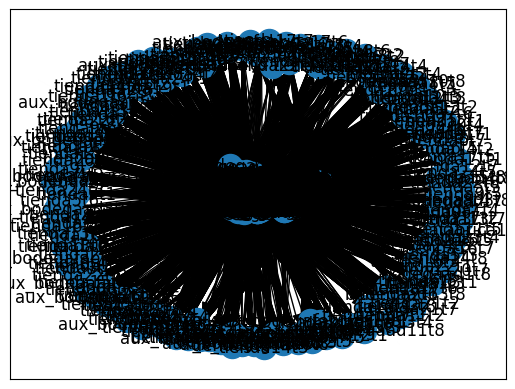

In [35]:
nx.draw_networkx(G1)

In [ ]:
hola